## dlfcompression.ipynb

Compression via double logistic functions.

In [1]:
import sys
sys.path.insert(0,'../cropseg/')

datasetinfo = { "datadir":"../data/",
                "metadatadir":"../data/metadata/",
                "dataset":"su_african_crops_ghana",
                "groundcollection":"su_african_crops_ghana_labels",
                "s1collection":"su_african_crops_ghana_source_s1",
                "s2collection":"su_african_crops_ghana_source_s2",
                "groundlabels":"su_african_crops_ghana_labels_id.json",
                "groundmetadata":"su_african_crops_ghana_labels.json",
                "s1metadata":"su_african_crops_ghana_source_s1.json",
                "s2metadata":"su_african_crops_ghana_source_s2.json",
                "groundname":"labels.tif",
                "s1imagename":"source.tif",
                "s2imagename":"source.tif",
                "s2maskname":"cloudmask.tif",
                "groundshape":[64,64],
                "s1shape":[64,64],
                "s2shape":[64,64],
                "extension":"tif"
              }
s1bands = [
            {"band":"vv","idx":0},
            {"band":"vh","idx":1},    
          ]  
s2bands = [
            {"band":"blue","wavelength":490,"idx":0},
            {"band":"green","wavelength":560,"idx":1},
            {"band":"red","wavelength":665,"idx":2},
            {"band":"rded1","wavelength":705,"idx":3},
            {"band":"rded2","wavelength":740,"idx":4},
            {"band":"rded3","wavelength":783,"idx":5},
            {"band":"nir","wavelength":842,"idx":6},
            {"band":"rded4","wavelength":865,"idx":7},
            {"band":"swir1","wavelength":1610,"idx":8},
            {"band":"swir2","wavelength":2190,"idx":9}
          ]
s1indices = ["vhvv"]
s2indices = ["ndvi","rdedci","ndmi"]

from mlhubdata import loadjson
groundlabels = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundlabels"]}')
groundmetadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundmetadata"]}')
s1metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s1metadata"]}')
s2metadata = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["s2metadata"]}')

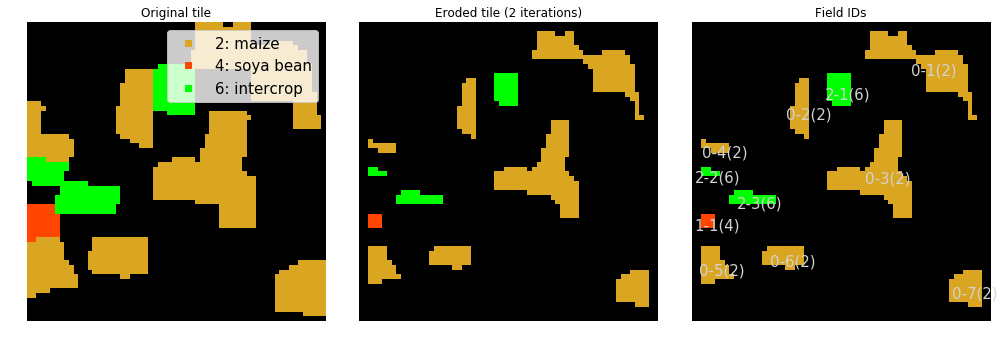

In [3]:
#####
tileid = "003186"
erosioniterations = 2
#####

import numpy
from osgeo import gdal
import matplotlib.pyplot
from PIL import ImageColor
import scipy.ndimage

from grounddata import erodedfieldmasks

tilehandle = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["groundcollection"]}/{datasetinfo["groundcollection"]}_{tileid}/{datasetinfo["groundname"]}')
tiledata = numpy.array(tilehandle.GetRasterBand(1).ReadAsArray(),dtype="int")
crops = numpy.unique(tiledata[tiledata != 0])
fieldmasks = erodedfieldmasks(tiledata,erosioniterations)

fig,ax = matplotlib.pyplot.subplots(1,3,figsize=[14,5])
axs = ax.ravel()
rgb = numpy.zeros([numpy.shape(tiledata)[0],numpy.shape(tiledata)[1],3],dtype=numpy.uint8)  
for i in range(len(fieldmasks)):
    colour = ImageColor.getcolor(groundlabels[crops[i]]["colour"],"RGB")
    for j in range(1,fieldmasks[i][1]+1):
        com = scipy.ndimage.center_of_mass(fieldmasks[i][0] == j)
        axs[2].text(com[1]-3,com[0]+2,s=f'{i}-{j}({groundlabels[crops[i]]["id"]})',color="lightgrey",size=15,zorder=10)
        rgb[fieldmasks[i][0] == j,0] = colour[0]
        rgb[fieldmasks[i][0] == j,1] = colour[1]
        rgb[fieldmasks[i][0] == j,2] = colour[2]
axs[1].imshow(rgb,interpolation=None,aspect="equal",zorder=5)
axs[2].imshow(rgb,interpolation=None,aspect="equal",zorder=5)       
for i in range(len(crops)):
    axs[0].plot(0,0,"s",color=groundlabels[crops[i]]["colour"],label=f'{groundlabels[crops[i]]["id"]}: {groundlabels[crops[i]]["crop"]}',zorder=0)
    colour = ImageColor.getcolor(groundlabels[crops[i]]["colour"],"RGB")
    rgb[tiledata == crops[i],0] = colour[0]
    rgb[tiledata == crops[i],1] = colour[1]
    rgb[tiledata == crops[i],2] = colour[2]
axs[0].legend(bbox_to_anchor=(1.0,1.0),loc="best",fontsize=15)
axs[0].imshow(rgb,interpolation=None,aspect="equal",zorder=5)    
axs[0].set_title("Original tile")      
axs[1].set_title(f'Eroded tile ({erosioniterations} iterations)')
axs[2].set_title("Field IDs")
axs[0].axis("off")
axs[1].axis("off")
axs[2].axis("off")
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [4]:
from mlhubdata import get_tileitems_from_collection
from satellitedata import load_satellite_data_as_array
from satellitedata import load_satellite_cloudmasks_as_array

s1items,s1dates = get_tileitems_from_collection(tileid,s1metadata,datasetinfo,verbose=1)
s2items,s2dates = get_tileitems_from_collection(tileid,s2metadata,datasetinfo,verbose=1)
s1data = load_satellite_data_as_array(s1items,s1bands,s1indices,datasetinfo,datasetinfo["s1shape"])
s2data = load_satellite_data_as_array(s2items,s2bands,s2indices,datasetinfo,datasetinfo["s2shape"],rr=4096.)
s2cloudmasks = load_satellite_cloudmasks_as_array(s2items,datasetinfo,datasetinfo["s2shape"])

Items for 003186 are available                                                                                                    
Items for 003186 are available                                                                                                    


/home/ucfaab0/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


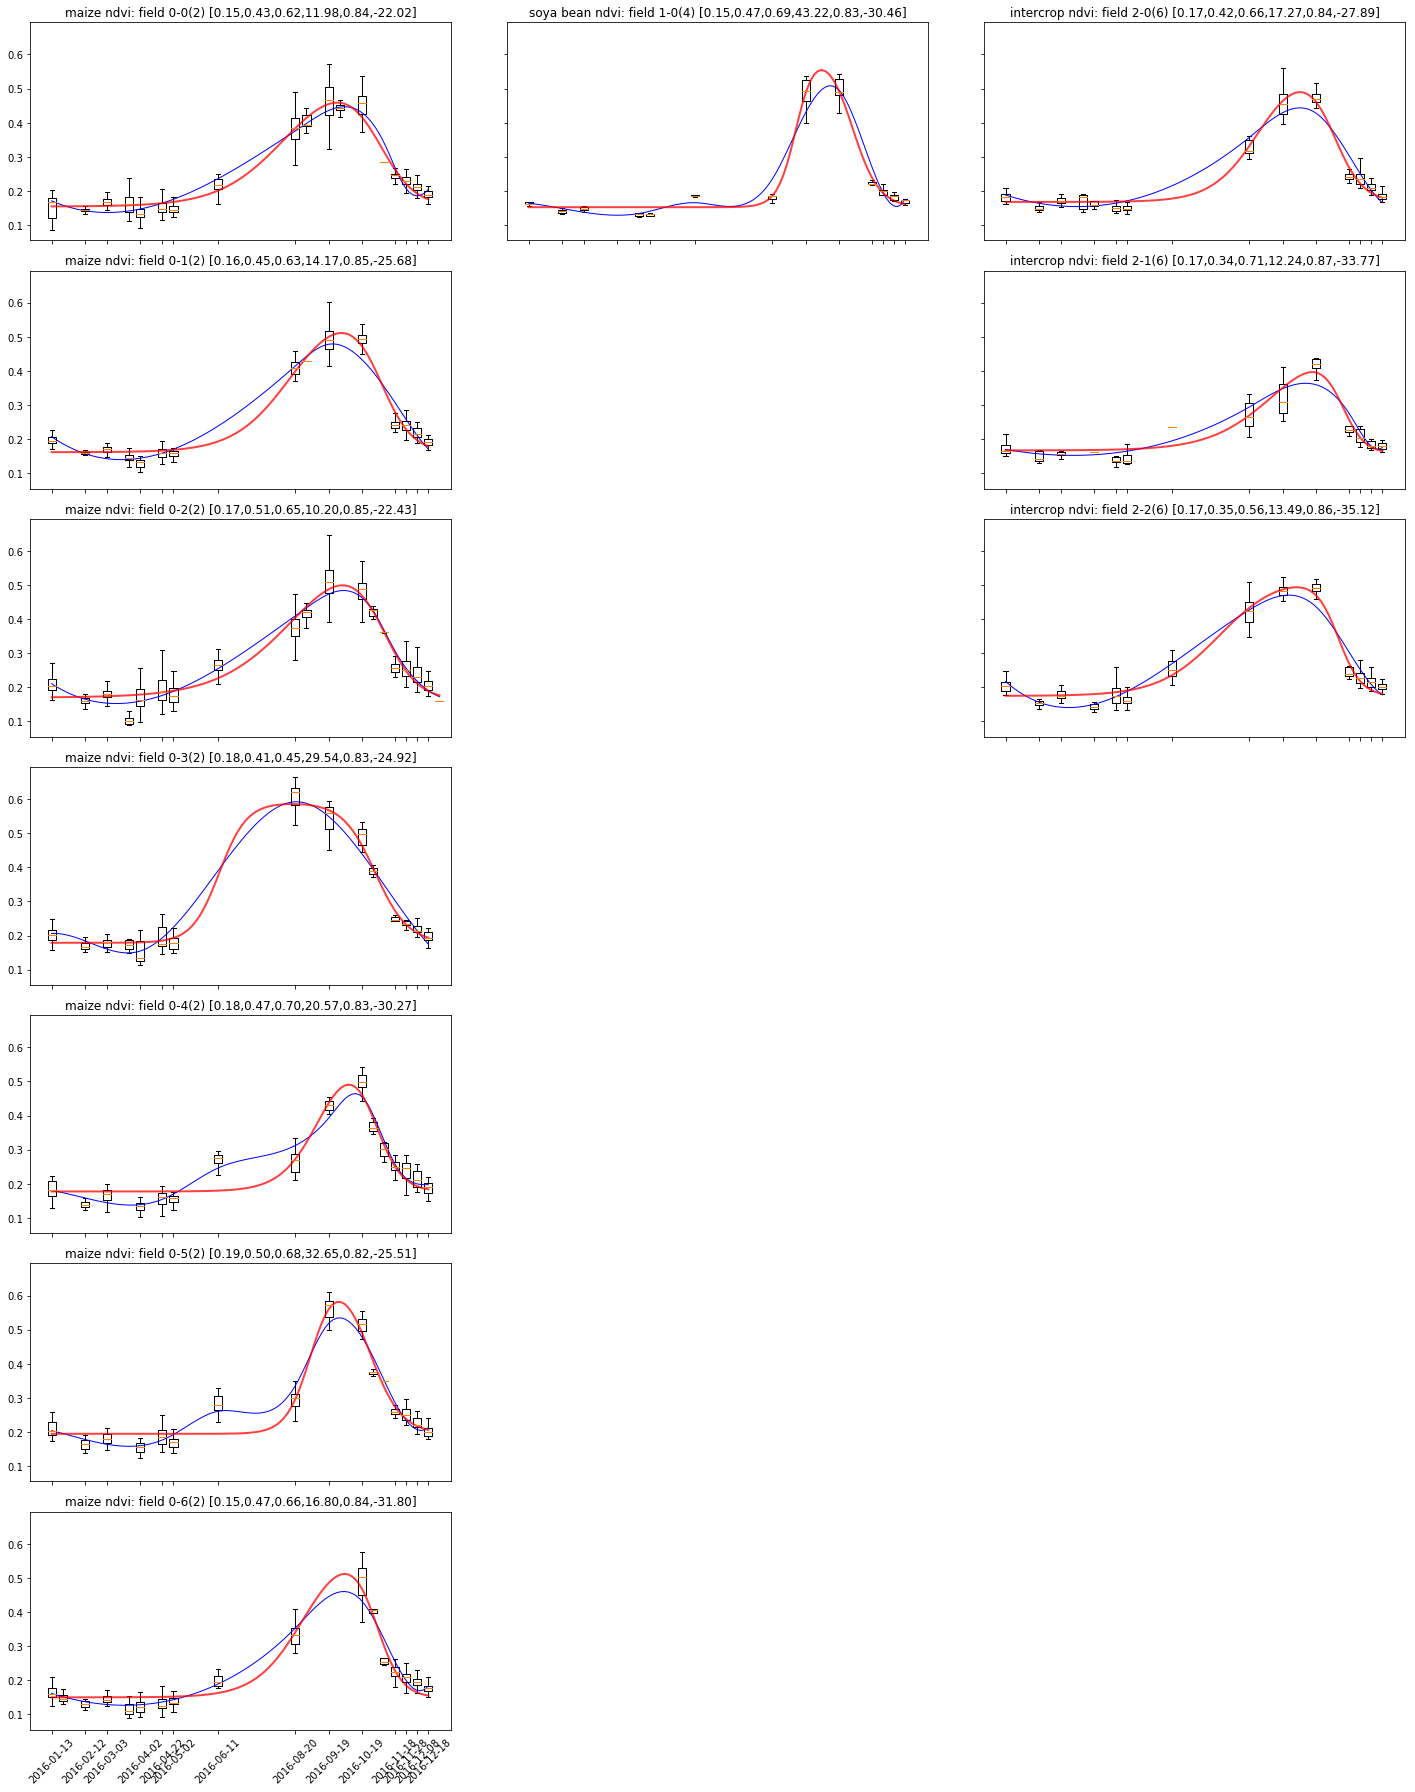

In [5]:
#####
index = s2indices.index("ndvi")
#####

import scipy.interpolate
from compression import doublelogistic
from compression import dbllogifunc
from compression import doublelogistic_fittingconditions
from compression import doublelogistic_parameterconditions
from miscellaneous import fusedataandweight
from dates import datepositions
from plotting import fieldmask_colrowcount

datapos = index + len(s2bands)
ncol,nrow = fieldmask_colrowcount(fieldmasks)
fig,ax = matplotlib.pyplot.subplots(nrow,ncol,figsize=[20,25],sharex="all",sharey="all")
axs = ax.ravel(order='F')
idx = 0
delete = []
for i in range(ncol):
    for j in range(nrow):
        if j < fieldmasks[i][1]:
            data = []
            mean = []
            dates = []
            for k in range(len(s2items)):
                fm = numpy.copy(fieldmasks[i][0])
                cm = numpy.copy(s2cloudmasks[k])
                fm[cm != 0] = 0                
                if len(s2data[k][datapos][fm == j+1]) > 0:
                    data.append(list(s2data[k][datapos][fm == j+1]))
                    mean.append(numpy.mean(s2data[k][datapos][fm == j+1]))
                    dates.append(s2dates[k])
            mean = numpy.array(mean)
            pos = numpy.array(datepositions(dates))
            axs[idx].boxplot(data,positions=pos,widths=0.02,showfliers=False)
            poss = numpy.linspace(numpy.min(pos),numpy.max(pos),100)
            spline = scipy.interpolate.UnivariateSpline(pos,mean,s=0.01,k=3)
            axs[idx].plot(poss,spline(poss),color="blue",alpha=1,lw=1)            
            if doublelogistic_fittingconditions(pos,mean,durationmin=0.9,gapmax=0.5,amplitudemin=0.25) == True:
                posf,meanf,weights = fusedataandweight(pos,mean,poss,spline(poss),weight=[0.1,1.0])
                dbllog = doublelogistic(posf,meanf,weights=weights,bound=True,epsilon=0.1)
                if doublelogistic_parameterconditions(dbllog,A1min=0.11,A1max=0.24,A2min=0.26,A2max=0.63,x01min=0.34,x01max=0.88,k1min=7.65,k1max=54.02,x02min=0.61,x02max=1.08,k2min=-43.89,k2max=-16.52) == True:
                    axs[idx].plot(posf,dbllogifunc(posf,*dbllog),color="red",alpha=0.75,lw=2)
                    axs[idx].set_title('{0} {1}: field {2}-{3}({4}) [{5:.2f},{6:.2f},{7:.2f},{8:.2f},{9:.2f},{10:.2f}]'.format(groundlabels[crops[i]]["crop"],s2indices[index],i,j,crops[i],dbllog[0],dbllog[1],dbllog[2],dbllog[3],dbllog[4],dbllog[5]))
            else:
                axs[idx].set_title(f'{groundlabels[crops[i]]["crop"]} {s2indices[index]}: field {i}-{j}({crops[i]})')
            axs[idx].set_xlim([-0.02,1.02])
            axs[idx].set_xticklabels(dates,rotation=45)
        else:
            delete.append(idx)
        idx = idx + 1
for i in range(len(delete)):
    fig.delaxes(axs[delete[i]])
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

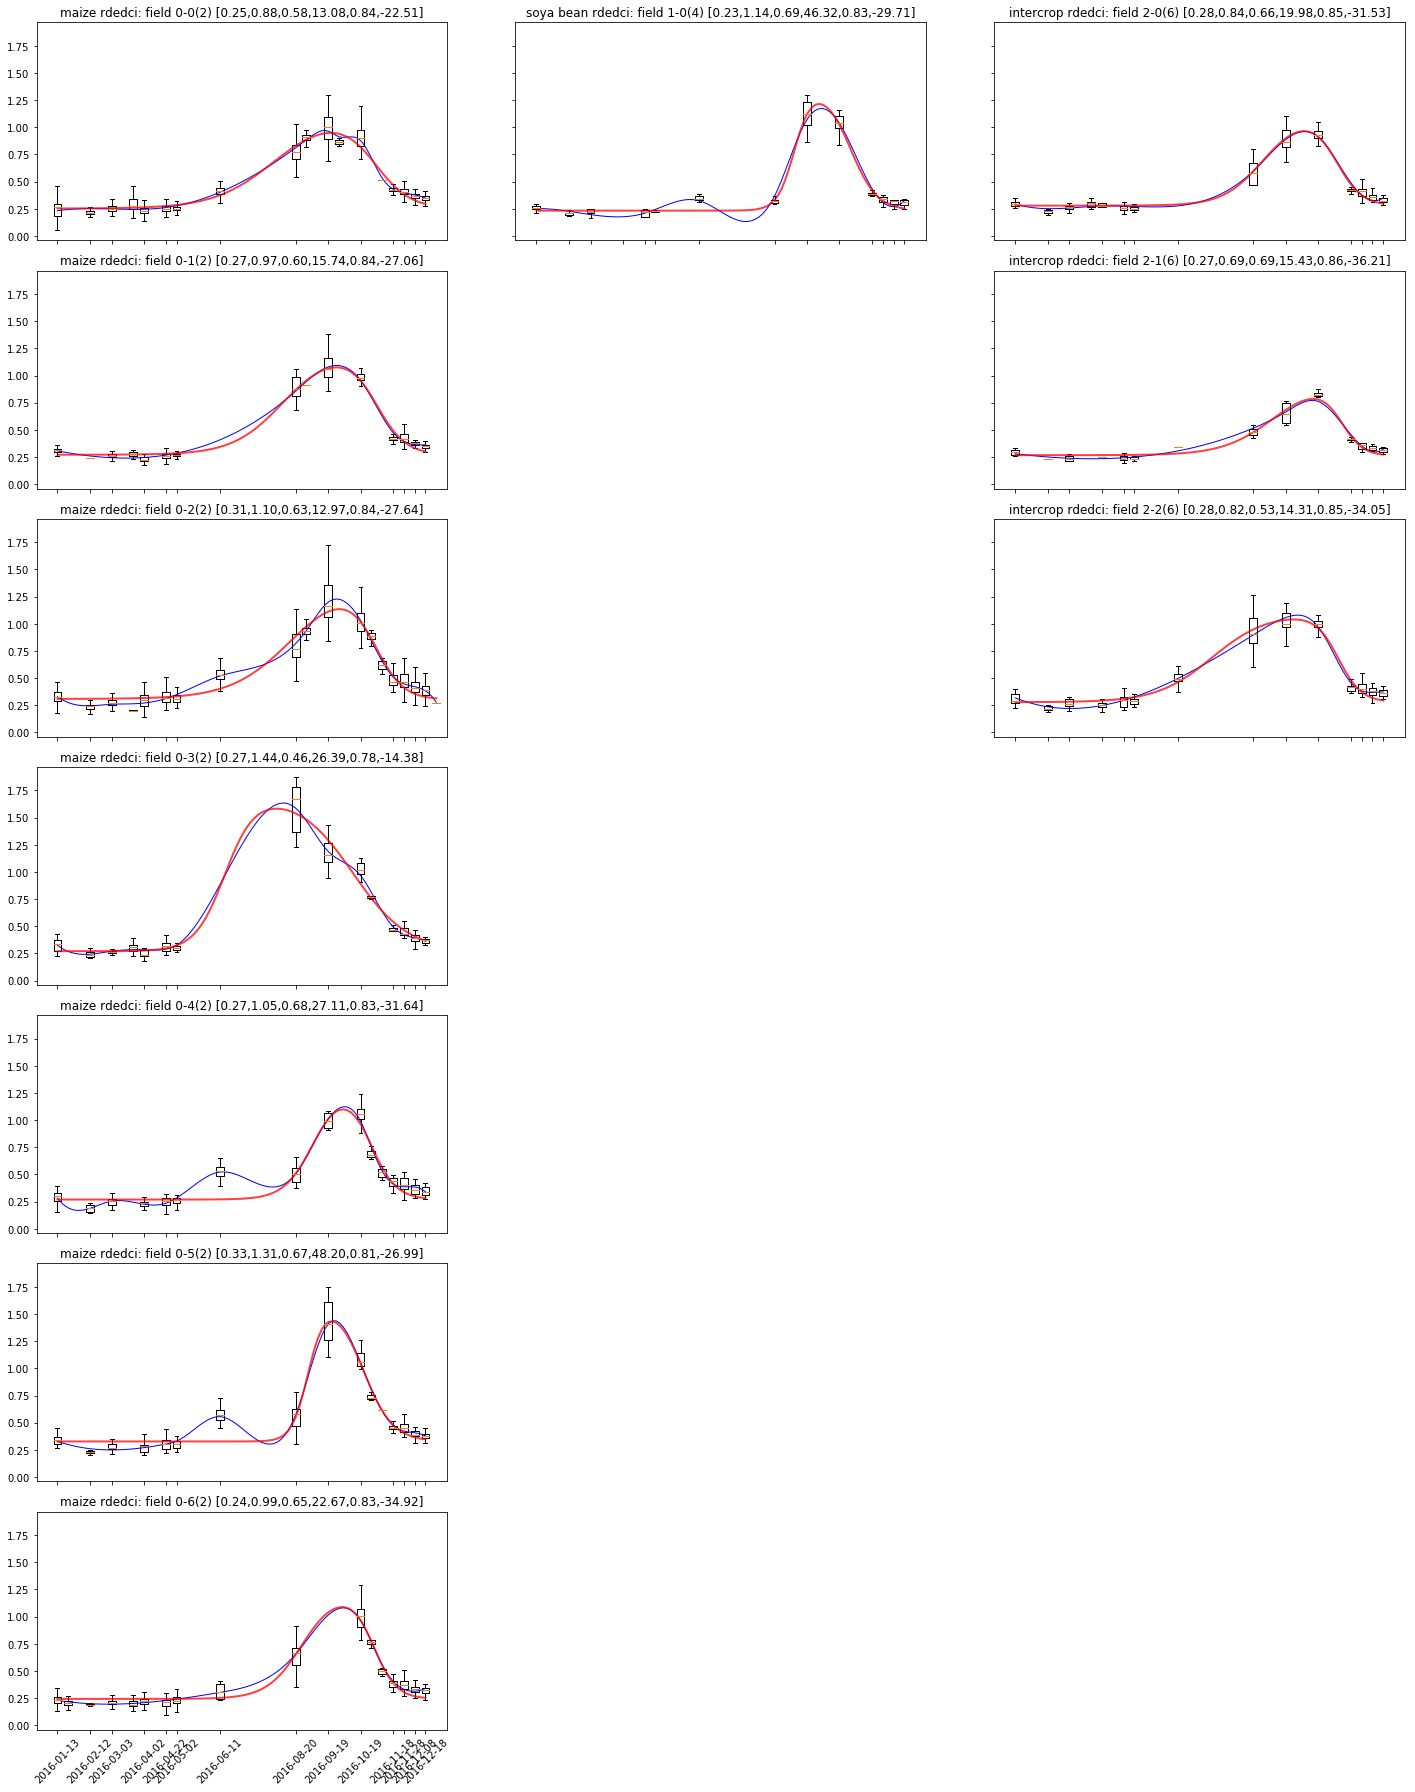

In [6]:
#####
index = s2indices.index("rdedci")
#####

datapos = index + len(s2bands)
ncol,nrow = fieldmask_colrowcount(fieldmasks)
fig,ax = matplotlib.pyplot.subplots(nrow,ncol,figsize=[20,25],sharex="all",sharey="all")
axs = ax.ravel(order='F')
idx = 0
delete = []
for i in range(ncol):
    for j in range(nrow):
        if j < fieldmasks[i][1]:
            data = []
            mean = []
            dates = []
            for k in range(len(s2items)):
                fm = numpy.copy(fieldmasks[i][0])
                cm = numpy.copy(s2cloudmasks[k])
                fm[cm != 0] = 0                
                if len(s2data[k][datapos][fm == j+1]) > 0:
                    data.append(list(s2data[k][datapos][fm == j+1]))
                    mean.append(numpy.mean(s2data[k][datapos][fm == j+1]))
                    dates.append(s2dates[k])
            mean = numpy.array(mean)
            pos = numpy.array(datepositions(dates))
            axs[idx].boxplot(data,positions=pos,widths=0.02,showfliers=False)
            poss = numpy.linspace(numpy.min(pos),numpy.max(pos),100)
            spline = scipy.interpolate.UnivariateSpline(pos,mean,s=0.01,k=3)
            axs[idx].plot(poss,spline(poss),color="blue",alpha=1,lw=1)            
            if doublelogistic_fittingconditions(pos,mean,durationmin=0.9,gapmax=0.5,amplitudemin=0.5) == True:
                posf,meanf,weights = fusedataandweight(pos,mean,poss,spline(poss),weight=[0.1,1.0])
                dbllog = doublelogistic(posf,meanf,weights=weights,bound=True,epsilon=0.1)
                if doublelogistic_parameterconditions(dbllog,A1min=0.17,A1max=0.41,A2min=0.52,A2max=1.80,x01min=0.34,x01max=0.86,k1min=9.73,k1max=60.25,x02min=0.59,x02max=1.07,k2min=-45.27,k2max=-10.78) == True:
                    axs[idx].plot(posf,dbllogifunc(posf,*dbllog),color="red",alpha=0.75,lw=2)
                    axs[idx].set_title('{0} {1}: field {2}-{3}({4}) [{5:.2f},{6:.2f},{7:.2f},{8:.2f},{9:.2f},{10:.2f}]'.format(groundlabels[crops[i]]["crop"],s2indices[index],i,j,crops[i],dbllog[0],dbllog[1],dbllog[2],dbllog[3],dbllog[4],dbllog[5]))
            else:
                axs[idx].set_title(f'{groundlabels[crops[i]]["crop"]} {s2indices[index]}: field {i}-{j}({crops[i]})')
            axs[idx].set_xlim([-0.02,1.02])
            axs[idx].set_xticklabels(dates,rotation=45)
        else:
            delete.append(idx)
        idx = idx + 1
for i in range(len(delete)):
    fig.delaxes(axs[delete[i]])
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

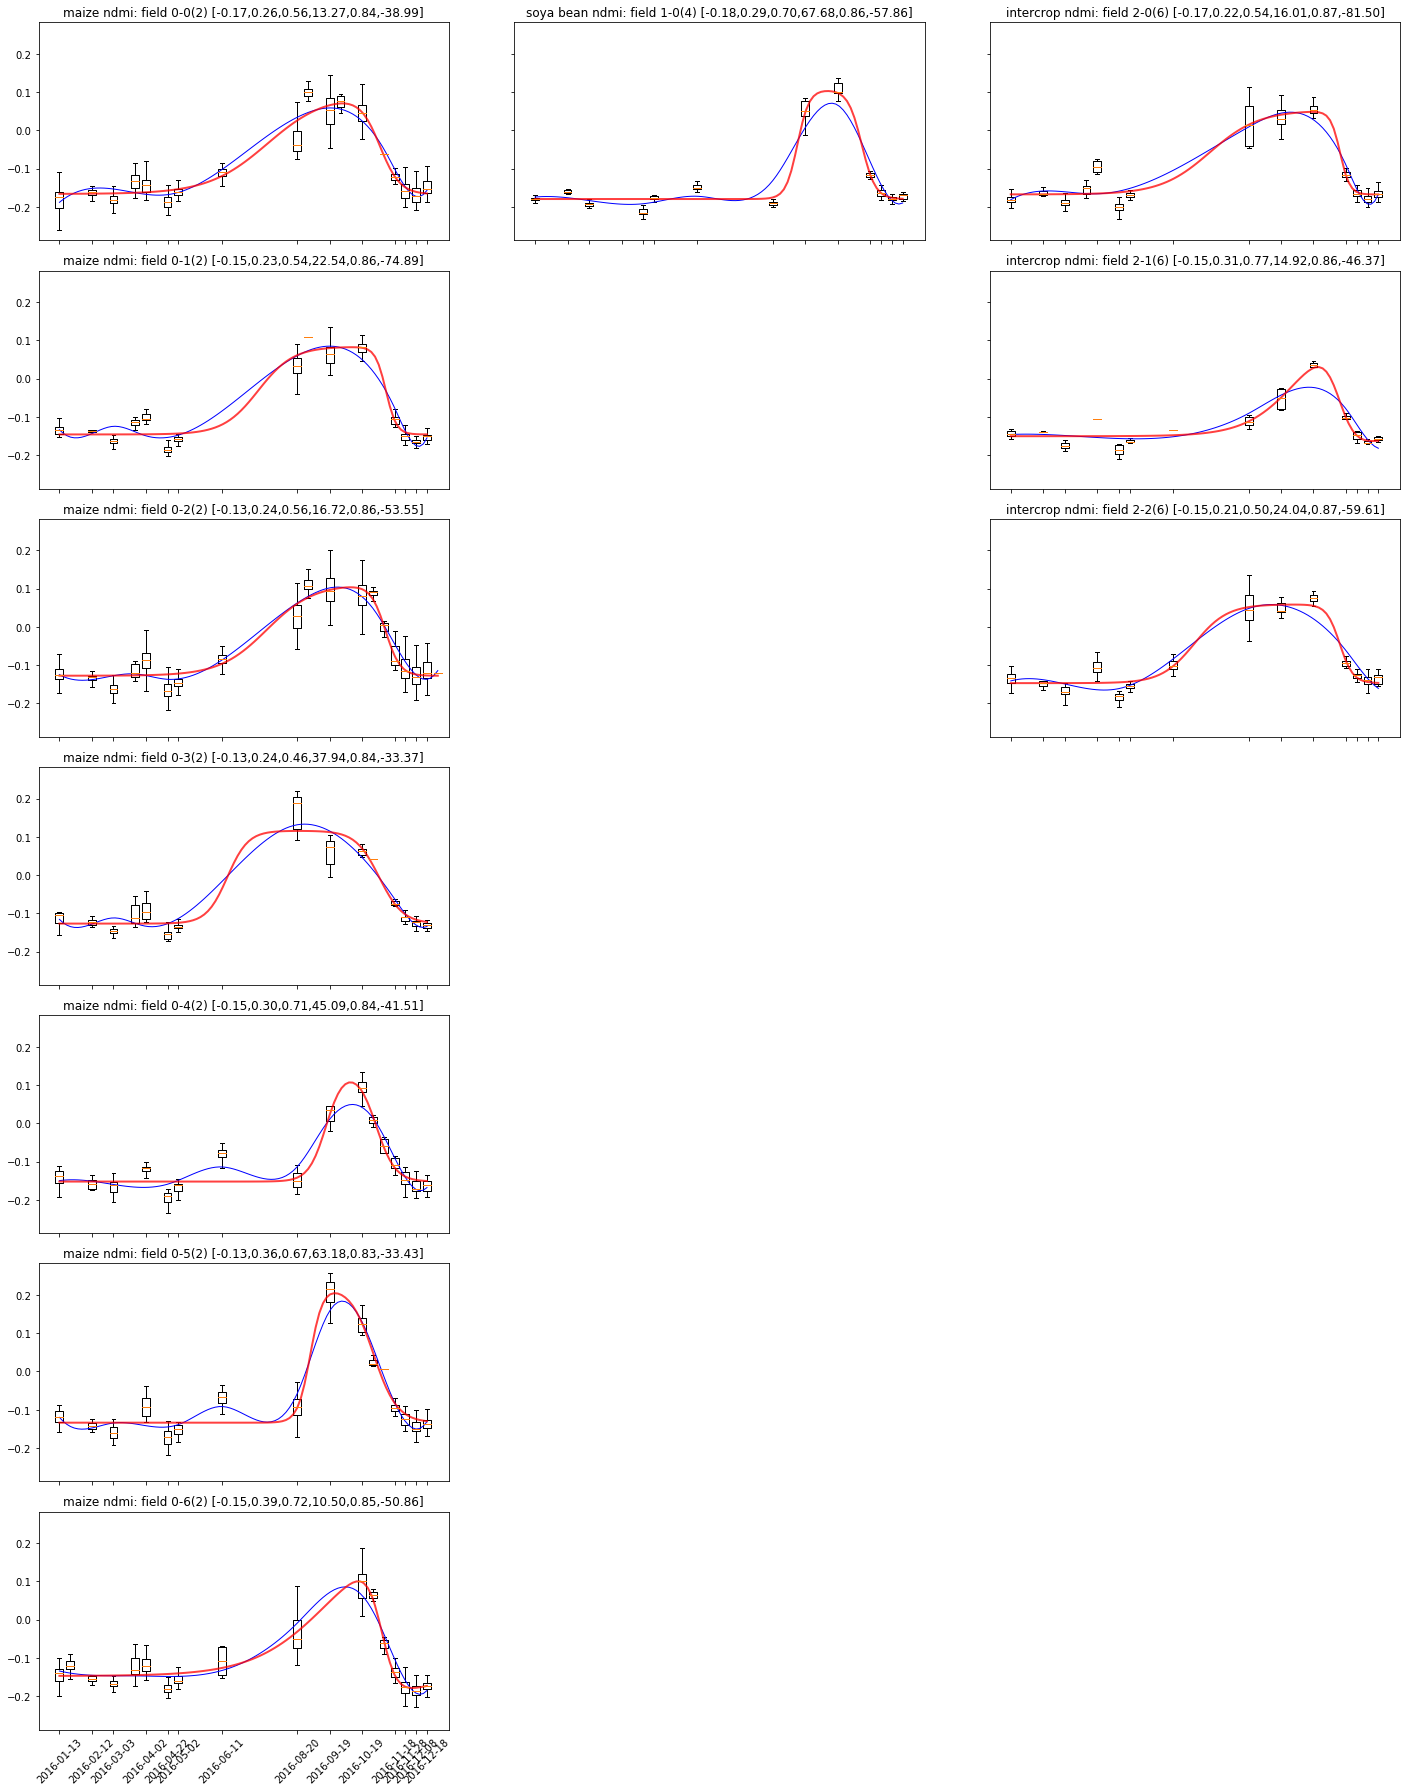

In [7]:
#####
index = s2indices.index("ndmi")
#####

datapos = index + len(s2bands)
ncol,nrow = fieldmask_colrowcount(fieldmasks)
fig,ax = matplotlib.pyplot.subplots(nrow,ncol,figsize=[20,25],sharex="all",sharey="all")
axs = ax.ravel(order='F')
idx = 0
delete = []
for i in range(ncol):
    for j in range(nrow):
        if j < fieldmasks[i][1]:
            data = []
            mean = []
            dates = []
            for k in range(len(s2items)):
                fm = numpy.copy(fieldmasks[i][0])
                cm = numpy.copy(s2cloudmasks[k])
                fm[cm != 0] = 0                
                if len(s2data[k][datapos][fm == j+1]) > 0:
                    data.append(list(s2data[k][datapos][fm == j+1]))
                    mean.append(numpy.mean(s2data[k][datapos][fm == j+1]))
                    dates.append(s2dates[k])
            mean = numpy.array(mean)
            pos = numpy.array(datepositions(dates))
            axs[idx].boxplot(data,positions=pos,widths=0.02,showfliers=False)
            poss = numpy.linspace(numpy.min(pos),numpy.max(pos),100)
            spline = scipy.interpolate.UnivariateSpline(pos,mean,s=0.01,k=3)
            axs[idx].plot(poss,spline(poss),color="blue",alpha=1,lw=1)            
            if doublelogistic_fittingconditions(pos,mean,durationmin=0.9,gapmax=0.5,amplitudemin=0.2) == True:
                posf,meanf,weights = fusedataandweight(pos,mean,poss,spline(poss),weight=[0.1,1.0])
                dbllog = doublelogistic(posf,meanf,weights=weights,bound=True,epsilon=0.1)
                if doublelogistic_parameterconditions(dbllog,A1min=-0.22,A1max=-0.09,A2min=0.15,A2max=0.49,x01min=0.34,x01max=0.96,k1min=7.88,k1max=84.59,x02min=0.62,x02max=1.08,k2min=-101.88,k2max=-25.03) == True:
                    axs[idx].plot(posf,dbllogifunc(posf,*dbllog),color="red",alpha=0.75,lw=2)
                    axs[idx].set_title('{0} {1}: field {2}-{3}({4}) [{5:.2f},{6:.2f},{7:.2f},{8:.2f},{9:.2f},{10:.2f}]'.format(groundlabels[crops[i]]["crop"],s2indices[index],i,j,crops[i],dbllog[0],dbllog[1],dbllog[2],dbllog[3],dbllog[4],dbllog[5]))
            else:
                axs[idx].set_title(f'{groundlabels[crops[i]]["crop"]} {s2indices[index]}: field {i}-{j}({crops[i]})')
            axs[idx].set_xlim([-0.02,1.02])
            axs[idx].set_xticklabels(dates,rotation=45)
        else:
            delete.append(idx)
        idx = idx + 1
for i in range(len(delete)):
    fig.delaxes(axs[delete[i]])
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()